<a href="https://colab.research.google.com/github/SaketMunda/food-vision-101/blob/master/food_vision101_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Vision App using Tensorflow

A Food Vision app which can tell from detecting the image that what kind of dish it is. The model will be trained by using all of the data from Food101 dataset.

Which has, 75,750 training images and 25,250 testing images of 101 classes (food item).

> **💡 Idea :** Using the food vision app model when user uploads an image, it can detect the image and then tell the amount of calories or micros on that dish based on the image detected. 

### Goal 

We'got the goal of beating [DeepFood](https://arxiv.org/abs/1606.05675), a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

## Check GPUs

Since we're going to use mixed precision training which helps the model to train faster (was introduced in [TensorFLow 2.4.0](https://blog.tensorflow.org/2020/12/whats-new-in-tensorflow-24.html)).

How it does ? In short it uses a combination of single precision (float32) and half precision (float16) datatypes to speed up model training (up 3x on modern GPUs).

But for mixed precision training to work, we need access to a GPU with a compatibility score of 7.0+

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-09684a47-424c-9183-8210-7e5c683074d5)


In [ ]:
!nvidia-smi

Mon Jan 16 06:40:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

And Tesla T4 has the compatibility score more than 7.0. **Thanks to Google colab for providing this GPU**. 

In [4]:
# Downgrading the tensorflow version
!pip install tensorflow==2.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.6/489.6 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/463.1 KB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.2
    Uninstalling tensorflow-2.9.2:
      Successfully uninstalled tensorflow-2.9.2


In [1]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Also check the version of Tensorflow


In [2]:
print(tf.__version__)

2.7.0


## Get Helper Functions

Import some of the helper functions that we created in `helper_functions.py` for unzipping data, walking through directories and few other stuffs.

In [3]:
# Get helper_functions.py script from Github
!wget https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, unzip_data, walk_through_dir, plot_loss_curves    

--2023-01-17 03:10:50--  https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2904 (2.8K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   2.84K  --.-KB/s    in 0s      

2023-01-17 03:10:51 (45.9 MB/s) - ‘helper_functions.py’ saved [2904/2904]



## Use TensorFlow Datasets To Download Data

For many of the popular datasets in the machine learning world (often referred to and used as benchmarks), we can access them through [TensorFLow Datasets (TFDS)](https://www.tensorflow.org/datasets/overview)

In [4]:
# get tensorflow datasets
import tensorflow_datasets as tfds

In [5]:
# List available datasets
datasets_list = tfds.list_builders() # get all the available datasets
print("food101" in datasets_list)

True


It looks like the dataset we're after is available (note there are plenty more availabel but we're on Food101)

To get acchess to the Food101 dataset from TFDS, we can use the `tfds.load()` method.

In [6]:
# Load in the data 
(train_data, test_data), ds_info = tfds.load(name='food101', # target dataset to get from TFDS
                                             split=['train', 'validation'], # What splits of data should we get ?
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g (image, label)
                                             with_info=True) # include dataset metadata ? if so, returns tuple(data, ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteZ7MG1L/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteZ7MG1L/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


Now let's get a little information from our dataset, starting with the class names.

Getting class names from a TensorFlow Datasets dataset requires downloading the `dataset_infor` variable (by using the `as_supervised=True` parameter) in the `tfds.load()` method.

In [7]:
# Features of food101 tfds
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
# Get the classnames
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring the Food101 dataset from TensorFlow Datasets

Let's find out a few details about our dataset,
- The shape of our input data (image tensors)
- The datatype of our input data
- What the labels of our input data look like (e.g one-hot encoded versus label-encoded)
- Do the labels match up with the class names ?

In [ ]:
# Take one sample of the training dat
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

So it says, one sample is in the format of tuples (image_tensor, label)

In [ ]:
for image, label in train_one_sample:
  print(f"""
  Image Shape : {image.shape}
  Image dtype : {image.dtype}
  Target Class(tensor form) : {label}
  Class name (str form): {class_names[label.numpy()]}
  """
  )


  Image Shape : (512, 512, 3)
  Image dtype : <dtype: 'uint8'>
  Target Class(tensor form) : 90
  Class name (str form): spaghetti_bolognese
  


Because we set the `shuffle_files=True` parameter in our `tfds.load()` method above, running the cell above a few times will give a different result everytime.

Checking these we can know that the shape of images have different shapes for example, (512, 512, 3) but all have the 3 color channels followed by height, width

Let's see what one of the image tensors from TFDS's Food101 dataset looks like.

In [ ]:
# What does an image tensor from TFDS look like
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 12,  13,   7],
        [ 12,  13,   7],
        [ 13,  14,   8],
        ...,
        [ 21,  11,   0],
        [ 21,  11,   0],
        [ 21,  11,   0]],

       [[ 12,  13,   7],
        [ 11,  12,   6],
        [ 11,  12,   6],
        ...,
        [ 21,  11,   0],
        [ 21,  11,   0],
        [ 21,  11,   0]],

       [[  7,   8,   2],
        [  7,   8,   2],
        [  7,   8,   2],
        ...,
        [ 22,  12,   2],
        [ 21,  11,   1],
        [ 20,  10,   0]],

       ...,

       [[188, 191, 184],
        [188, 191, 184],
        [188, 191, 184],
        ...,
        [243, 248, 244],
        [243, 248, 244],
        [242, 247, 243]],

       [[187, 190, 183],
        [189, 192, 185],
        [190, 193, 186],
        ...,
        [241, 245, 244],
        [241, 245, 244],
        [241, 245, 244]],

       [[186, 189, 182],
        [189, 192, 185],
        [191, 194, 187],
        ...,
        [238, 242, 24

I guess, the range of values of the above must be 0-255 as we all know that images have pixel values of (0,255)

In [ ]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

There we go !

Now let's visualize by plotting one of the image with the label name to make things clear

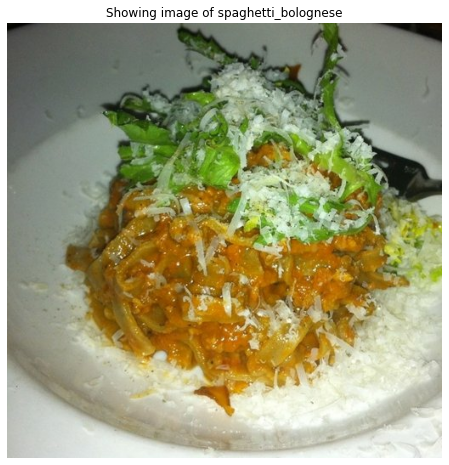

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.title(f'Showing image of {class_names[label.numpy()]}')
plt.imshow(image)
plt.axis(False);

Healthy ! Looks like the Food101 data we've got from TFDS is similar to the datasets we've been using in previous notebooks.

Now let's preprocess it and get it ready for use with a neural network.

## Create preprocessing functions of our data

There are a couple of of preprocessing steps we have to take before it's ready to model,

More specifically, our data is currently:
- In `uint8` datatype
- Comprised of all different size tensors(different sized image)
- Not scaled (the pixel values are between 0 & 255)

Whereas, models like the data to be:
- In `float32` datatype
- Have all of the same size tensors (batches require all tensors have the same shape, e.g `(224, 224, 3)`)
- Scaled (values between 0 & 1), also called normalized

In [9]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224, scale=False):
  """
  Converts image datatype from `uint8` to `float32` and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape

  if scale:
    image = image/255.
  
  return tf.cast(image, tf.float32), label

Let's try our function out on a target image

In [ ]:
preprocess__one_img = preprocess_img(image=image, 
                                     label=label)

In [ ]:
preprocess__one_img[0]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[1.1586735e+01, 1.2586735e+01, 6.5867348e+00],
        [1.1714286e+01, 1.2714286e+01, 6.7142859e+00],
        [8.8571424e+00, 9.8571424e+00, 4.8571424e+00],
        ...,
        [2.0714308e+01, 1.1142836e+01, 1.2857144e+00],
        [2.0668371e+01, 1.0668372e+01, 0.0000000e+00],
        [2.1000000e+01, 1.1000000e+01, 0.0000000e+00]],

       [[2.3571415e+00, 3.3571415e+00, 1.4285660e-01],
        [3.1530607e+00, 4.1530609e+00, 7.6530278e-02],
        [3.0561223e+00, 4.0561223e+00, 0.0000000e+00],
        ...,
        [2.6071407e+01, 1.8071407e+01, 7.0714073e+00],
        [2.4785702e+01, 1.4785702e+01, 4.7857018e+00],
        [2.2499966e+01, 1.2499966e+01, 2.4999657e+00]],

       [[1.3520410e+00, 2.3520410e+00, 0.0000000e+00],
        [3.0408173e+00, 4.0408173e+00, 6.1224538e-01],
        [7.2346954e+00, 8.1887770e+00, 3.3265321e+00],
        ...,
        [2.5479622e+01, 1.7382635e+01, 8.3826580e+00],
        [2.6056133e+01

It looks like it casted it into float32 and also changed the shape to (224, 224, 3)

## Batch and prepare datasets

Before we can model our data, we have to turn it into batches.

Because computing on batches is memory efficient.

We turn our data from 101,000 images tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU.

To do this in effective way, we're going to be leveraging a number of methods from `tf.data` API.

Specifically, we're going to be using:

- `map()` - maps a predefined function to a target dataset (e.g. `preprocess_img()` to our image tensors)
- `shuffle()` - randomly shuffles the element of a target dataset up `buffer_size` (ideally, the `buffer_size` is equal to the size of the dataset, however, this may have implications on memory)
- `batch()` - turns elements of a target dataset into batches (size defined by parameter `batch_size`)
- `prefetch()` - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but **costs memory**)
- Extra: `cache()` - caches (save them for later) elements in a target dataset, saving loading time 


In [10]:
# let's process the images first
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# shuffle train_data and turn it into bacthes and prefetch it
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# map preprocessing to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# turn it into batches and prefetch it
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

Looks like our data is converted into PrefetchDataset and also in the batches, hence the shape is (None, 224, 224, 3) as it rescales as well and casted into `float32`

## Create modelling callbacks

We have created `Tensorboard` callbacks in our helper functions, and also imported at the beginning of this notebook, so only need to create `ModelCheckpoint` callback to save the model checkpoints as it's very helpful so that when we fine-tune our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits.

In [55]:
# Create modelcheckpoint callback to save model's progress
checkpoint_path = 'model_checkpoints/cp.cpkt' # saving weights requires ".ckpt" extension

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_accuracy', 
                                                      save_best_only=True,                                                     
                                                      save_weights_only=True,
                                                      mode='max',
                                                      verbose=0)

## Setup Mixed Precision

Normally tensors in TensorFlow default to float32 datatypes (float32 is also known as single-precision floating-point format).

The 32 means it usually occupies 32 bits in computer memory.

Our GPU has a limited memory, therefore it can handle a number of float32 tensors at the same time.

This is where mixed precision training comes in.

Mixed precision training involves mixing of float32 and float16(half-precision floating-point format) tensors to make better use of our GPU's memory.

When using mixed precision training, our model will make use of float32 and float16 data types to use less memory where possible and in turn run faster (using less memory per tensor means more tensors can be computed on simultaneously).

Guide: https://www.tensorflow.org/guide/mixed_precision

In [12]:
# Turn on Mixed precision
from tensorflow.keras import mixed_precision

# set the float16 mixed precision
mixed_precision.set_global_policy('mixed_float16')

View what mixed precision is set,


In [56]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [14]:
policy = mixed_precision.Policy('mixed_float16')

print(f'Compute dtype: {policy.compute_dtype}')
print(f'Variable dtype: {policy.variable_dtype}')

Compute dtype: float16
Variable dtype: float32


Since we are now enabled `mixed_precision` for mixed precision training, our model needs a separate output layer with a hard-coded `dtype=tf.float32`, for example, `layers.Activation("softmax", dtype=tf.float32)`. This ensures the outputs of our model are returned back to our float32 datatype which is more numerically stable than the float16 datatype (important for loss calculations)

In [ ]:
print(tf.__version__)

2.7.0


## Build feature extraction model

In [57]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False # freeze base model layers

# Create functional model
inputs = layers.Input(shape=input_shape, name='input_layer')
# if we're using models other than EfficientNetBX, then we would preprocessing layer to rescale the images
#x = layers.Rescaling(1./255)(inputs)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name='pooling_layer')(x)
x = layers.Dense(len(class_names))(x)
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", name='activation_layer', dtype=tf.float32)(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', # Using sparse_categorical_crossentropy when lables are not one-hot encoded
              optimizer='Adam',
              metrics=['accuracy'])

In [ ]:
# check the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 activation_layer (Activatio  (None, 101)              0         
 n)                                                              
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Checking layer dtype policies (are we using mixed precision ?)
Let's check the datatypes of each layers

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
activation_layer True float32 <Policy "float32">


We can see that except input and output layer all have float16 dtype_policy, this is because we enabled mixed precision training.

let's check the base_model's layers,

In [ ]:
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

Here also all the layers have dtype_policy as float16. Alright !

Let's move into training our model, means fit our model with train data and then evaluate it with test data.

## Fit the feature extraction model

In [58]:
history_feature_extraction = model.fit(train_data,
                                       epochs=3,
                                       steps_per_epoch=len(train_data),
                                       validation_data=test_data,
                                       validation_steps=int(0.15 * len(test_data)),
                                       callbacks=[create_tensorboard_callback(dir_name='training_logs',
                                                                              experiment_name='foodvision_bigmodel_feature_extraction'),
                                                  model_checkpoint])

Saving Tensorboard log files to: training_logs/foodvision_bigmodel_feature_extraction/20230117-044000
Epoch 1/3


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - 187s 76ms/step - loss: 1.8240 - accuracy: 0.5577 - val_loss: 1.2258 - val_accuracy: 0.6801
Epoch 2/3
2368/2368 [==============================] - 183s 76ms/step - loss: 1.2940 - accuracy: 0.6655 - val_loss: 1.1156 - val_accuracy: 0.7044
Epoch 3/3
2368/2368 [==============================] - 174s 73ms/step - loss: 1.1435 - accuracy: 0.7013 - val_loss: 1.0848 - val_accuracy: 0.7137


Let's evaluate it on the whole `test_data`

In [59]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 53s 67ms/step - loss: 1.0875 - accuracy: 0.7081


[1.0874803066253662, 0.7081187963485718]

In [18]:
# checking the model's summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 activation_layer (Activatio  (None, 101)              0         
 n)                                                              
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Load and evaluate checkpoint weights

We can load in and evaluate our model's checkpoints by:

1. Cloning our model using `tf.keras.models.clone_model()` to make a copy of our feature extraction model with reset weights
2. Calling the `load_weights()` method on our clones model passing it the path to where our checkpointed weights are stored.
3. Calling `evaluate()` on the cloned model with loaded weights.

In [60]:
cloned_model = tf.keras.models.clone_model(model=model)
cloned_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                                 
 activation_layer (Activatio  (None, 101)              0         
 n)                                                              
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

The structure of `cloned_model` and a trained `model` looks same and it's parameter.

In [61]:
# load the weights from the checkpoint path
checkpoint_path

'model_checkpoints/cp.cpkt'

In [62]:
cloned_model.load_weights(checkpoint_path)

Each time we make changes to our model or load weights from the checkpoint path, we have to recompile the model

In [63]:
cloned_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer='Adam',                     
                     metrics=['accuracy'])

In [64]:
# evaluate the model
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)
results_cloned_model_with_loaded_weights

790/790 [==============================] - 55s 67ms/step - loss: 1.7181 - accuracy: 0.5501


[1.7181307077407837, 0.5500593781471252]

These results should be very close to the feature extraction model's results but it isn't let's try by comparing with `np.isclose()`

In [65]:
# Loaded checkpoint weights should return very similar results to checkpoint weights prior to saving,
import numpy as np
np.isclose(results_feature_extract_model, results_cloned_model_with_loaded_weights).all()

False

> **Why** ? 
Because Cloning the model preserves `dtype_policy`'s of layers (**but doesn't preserve weights**) so if we wanted to continue fine-tuning with the cloned model, we could it would still use the mixed precision dtype policy.

## Visualizing and comparing the weights of Models (To do)

In [ ]:
#To Do
# import matplotlib.pyplot as plt

# # def hist_weights(weights, bins=500):
# #   for weight in weights:
# #     plt.hist(weight, bins=bins)

# W = model.layers[1].get_weights() # getting the feature extracted model weights

# for w in W[:5]:
#   print(w)
#   print(w.shape)

#hist_weights(W)

## Save the whole model to file

We can save the whole model using the `save()` method

In [68]:
import os

save_dir = 'drive/MyDrive/Data Science/FoodVision101/efficientnetb0_feature_extraction_model_mixed_precision'

# make dir if not exist
os.makedirs(save_dir)

# save the model
model.save(save_dir)

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


And again, we can check whether or not our model saved correctly by loading it in evaluating it

In [ ]:
# loaded_saved_model = tf.keras.models.load_model(save_dir)

## Preparing our model for fine-tuning

Let's fine tuned the above loaded model that we feature extracted and achieved `70%` approx validation accuracy in our full test data set.

For fine-tuning, we might need to create some more callbacks to save the model's progress.

In [69]:
# Setup earlystopping callback to stop training if model's loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3)

checkpoint_path = 'fine_tune_checkpoints/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_loss',
                                                      save_best_only = True)

We're almost ready to fine-tune our model, but there is one more callback that we should use, `ReduceLROnPlateau`.

It helps to tune the learning rate for us.

Like the `ModelCheckpoint` and `EarlyStopping` callbacks, the `ReduceLROnPlateau` callback monitors a specified metric and when that metric stops improving, it reduces the learning rate by a specified factor (e.g. divides the learning rate by 10).

As the training goes on and our model gets closer and closer to ideal's performance (also called **convergence**), we want to the amount it learns to be less and less.

To do this we'll create an instance of the `ReduceLROnPlateau` callback to monitor the validation loss just like the `EarlyStopping` callback.

Once the validation loss stops improving for two or more epochs, we'll reduce the learning rate by a factor of 5 (e.g. `0.001` to `0.0002`).

And to make sure the learning rate doesn't get too low (and potentially result in our model learning nothing), we'll set the minimum learning rate to `1e-7`.

In [70]:
# creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2, # this is equal to the number of epochs approx
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

To fine-tune the model, let's make all the layer trainable which means we have to unfreeze all the layers

In [72]:
for layer in model.layers:
  layer.trainable=True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_2 True float32 <Policy "mixed_float16">
activation_layer True float32 <Policy "float32">


Checking some layers of `base_model` as well,

In [73]:
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 True float32 <Policy "float32">
rescaling_2 True float32 <Policy "mixed_float16">
normalization_2 True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "m

It seems all the layers inside the `base_model` is trainable and unfrozen, let's keep it that way because we have enough data to train them.

In [74]:
# compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [75]:
history_fine_tune_model = model.fit(train_data,
                                    epochs=100,
                                    steps_per_epoch=len(train_data),
                                    validation_data=test_data,
                                    validation_steps=int(0.15 * len(test_data)),
                                    callbacks=[create_tensorboard_callback("training_logs", "efficient_net_fine_tune"),
                                               model_checkpoint,
                                               early_stopping,
                                               reduce_lr])

Saving Tensorboard log files to: training_logs/efficient_net_fine_tune/20230117-052446


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.9211 - accuracy: 0.7528

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 395s 160ms/step - loss: 0.9211 - accuracy: 0.7528 - val_loss: 0.8099 - val_accuracy: 0.7778 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.5816 - accuracy: 0.8393

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 395s 166ms/step - loss: 0.5816 - accuracy: 0.8393 - val_loss: 0.7745 - val_accuracy: 0.7926 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 331s 139ms/step - loss: 0.3336 - accuracy: 0.9047 - val_loss: 0.9448 - val_accuracy: 0.7640 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1747 - accuracy: 0.9478
Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 335s 141ms/step - loss: 0.1747 - accuracy: 0.9478 - val_loss: 0.9920 - val_accuracy: 0.7775 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 330s 139ms/step - loss: 0.0364 - accuracy: 0.9916 - val_loss: 1.0556 - val_accuracy: 0.7990 - lr: 2.0000e-05


In [76]:
# saving the fine-tine model

save_dir_fine_tune = 'drive/MyDrive/Data Science/FoodVision101/efficientnetb0_fine_tuned_model_mixed_precision'

# make dir if not exist
os.makedirs(save_dir_fine_tune)

# save the model
model.save(save_dir_fine_tune)

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [77]:
# evaluate the model on whole test_data
results_fine_tune = model.evaluate(test_data)
results_fine_tune

790/790 [==============================] - 52s 66ms/step - loss: 1.0384 - accuracy: 0.7991


[1.0383766889572144, 0.7990891337394714]

Great it looks like, we have achieved almost 80% of accuracy on test dataset. Let's do further evaluations.